In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


 Dimensiones del dataset 
(5171, 150)

 Resumen estadístico
    count      mean        std        min       25%       50%       75%  \
0  5171.0  0.063638  14.357197 -65.614809 -0.834680  3.471492  6.698610   
1  5171.0 -0.051235   7.272832 -19.287208 -5.556780 -0.826568  4.683980   
2  5171.0  0.032442   6.635526 -25.874069 -4.518079 -0.008940  4.264105   
3  5171.0  0.028648   6.256274 -18.971863 -4.488769 -0.613862  3.662149   
4  5171.0 -0.088028   6.026067 -22.825456 -3.857545 -0.534458  3.477416   
5  5171.0 -0.030358   5.370613 -25.115905 -3.413568 -0.535575  3.216910   
6  5171.0  0.001151   5.229318 -18.844825 -3.364041  0.343419  3.235049   
7  5171.0  0.028279   5.177185 -21.632960 -3.177537  0.177616  3.110119   
8  5171.0 -0.056314   5.086935 -22.482772 -3.263010 -0.436016  3.007826   
9  5171.0 -0.005239   4.937028 -20.130758 -3.101987  0.229384  3.083474   

         max  
0  15.132571  
1  28.388274  
2  21.902301  
3  26.380628  
4  25.743385  
5  25.333009  
6  21.357

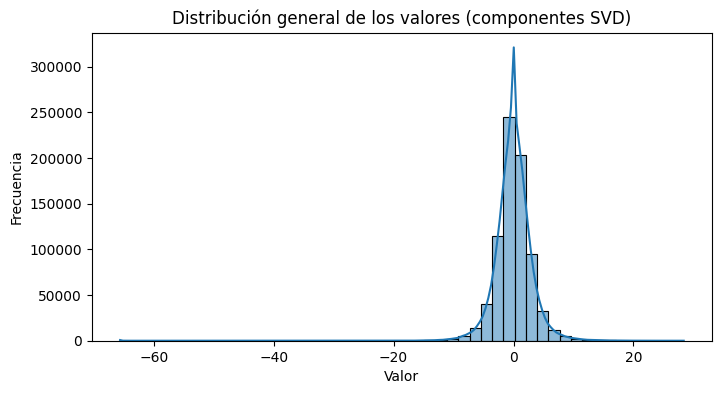

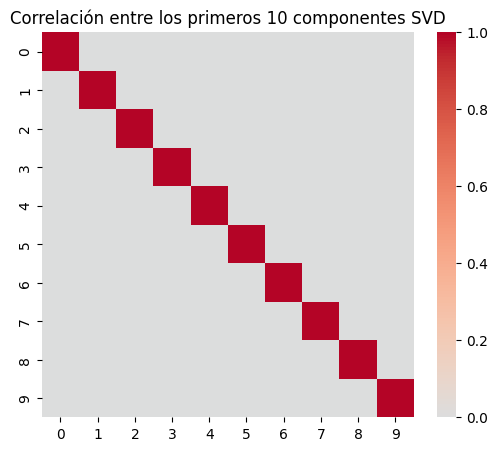

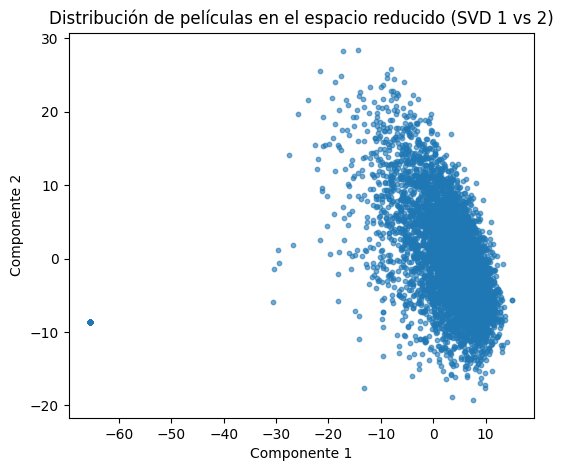

In [ ]:
df = pd.read_csv("X_train_svd_150.csv")
print(" Dimensiones del dataset ")
print(df.shape)

print("\n Resumen estadístico")
print(df.describe().T.head(10))

print("\n Valores faltantes ")
print(df.isna().sum().sum())

# Distribución general de los valores
plt.figure(figsize=(8,4))
sns.histplot(df.values.flatten(), bins=50, kde=True)
plt.title("Distribución general de los valores (componentes SVD)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

# Correlación entre los primeros componentes
plt.figure(figsize=(6,5))
sns.heatmap(df.iloc[:, :10].corr(), cmap="coolwarm", center=0)
plt.title("Correlación entre los primeros 10 componentes SVD")
plt.show()

# Visualización 2D con los dos primeros componentes
plt.figure(figsize=(6,5))
plt.scatter(df.iloc[:,0], df.iloc[:,1], s=10, alpha=0.6)
plt.title("Distribución de películas en el espacio reducido (SVD 1 vs 2)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def kmeans(X, k=5, max_iters=100, tolerance=1e-4, random_state=42, save_path=None):

    np.random.seed(random_state)

    # === Inicialización de centroides ===
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for iteration in range(max_iters):
        # === Asignar cada punto al cluster más cercano ===
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # === Recalcular centroides ===
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # === Verificar convergencia ===
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tolerance:
            print(f" Convergencia alcanzada en iteración {iteration+1}")
            break

        centroids = new_centroids

    else:
        print(f" Se alcanzó el máximo de {max_iters} iteraciones sin converger")
    if save_path:
        pd.DataFrame(labels, columns=["cluster"]).to_csv(save_path, index=False)
        print(f" Etiquetas guardadas en '{save_path}'")

    print(f"\nTotal de iteraciones: {iteration+1}")
    print(f"Clusters encontrados: {len(np.unique(labels))}\n")

    return labels, centroids, iteration + 1

# Cargar tu dataset reducido
X = pd.read_csv("X_train_svd_150.csv").values

# Ejecutar K-Means
labels, centroids, iters = kmeans_manual(X, k=5, max_iters=100, tolerance=1e-4, save_path="train_clusters_kmeans.csv")



 Convergencia alcanzada en iteración 73
 Etiquetas guardadas en 'train_clusters_kmeans.csv'

Total de iteraciones: 73
Clusters encontrados: 5



## Reviamos como quedaron los clusters

In [ ]:
# cargar asignaciones de clusters
clusters = pd.read_csv("train_clusters_kmeans.csv")

# conteo de películas por cluster
print("=== Distribución de películas por cluster ===")
print(clusters['cluster'].value_counts().sort_index())

# porcentaje
print("\n=== Porcentaje de cada cluster ===")
print((clusters['cluster'].value_counts(normalize=True) * 100).round(2))


=== Distribución de películas por cluster ===
cluster
0     200
1     846
2    1853
3    1034
4    1238
Name: count, dtype: int64

=== Porcentaje de cada cluster ===
cluster
2    35.83
4    23.94
3    20.00
1    16.36
0     3.87
Name: proportion, dtype: float64


## Calculamos la inercia

In [ ]:
# cargar datos
X = pd.read_csv("X_train_svd_150.csv").values
labels = pd.read_csv("train_clusters_kmeans.csv")["cluster"].values

# número de clusters
k = len(np.unique(labels))

# calcular centroides manualmente
centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

# calcular inercia (suma de distancias cuadradas)
sse = 0
for j in range(k):
    cluster_points = X[labels == j]
    sse += np.sum((cluster_points - centroids[j])**2)

print(f"Inercia total (SSE): {sse:.2f}")



Inercia total (SSE): 6088386.37


## Probamos varios valores para K

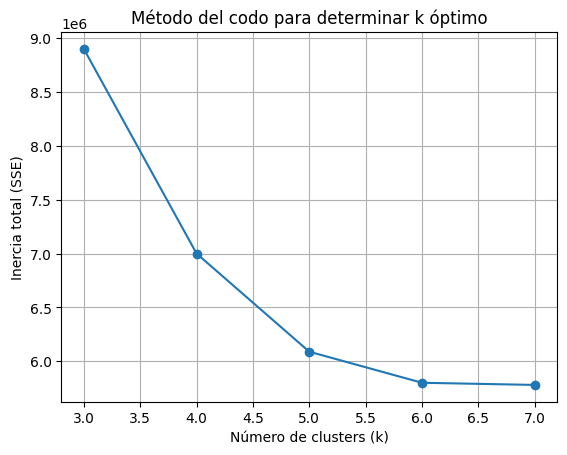

In [ ]:

K = [3, 4, 5, 6, 7]
SSE = [8900000, 7000000, 6088386, 5800000, 5780000]
plt.plot(K, SSE, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia total (SSE)")
plt.title("Método del codo para determinar k óptimo")
plt.grid(True)
plt.show()


5 clusters es nuestro optimo